# Optimización industrial con Computación Evolutiva 
Dr. Edwin Villanueva Talavera (ervillanueva@pucp.edu.pe)
Dra. Soledad Espezua Llerena (sespezua@pucp.edu.pe )

In [1]:
import sys
import time

import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime

import matplotlib.pyplot as plt
import heapq
import math

from random import shuffle, random, sample, randint, uniform, randrange

from math import exp

### Funciones utilitarias para manejar el tablero del sudoku </b>
Estas son funciones utilitarias para trabajar con tableros de sudoku  

In [2]:

# Funcion para cargar el tablero del sudoku de un archivo
def readBoardFromFile(filename):
    fd = open(filename,"r+")    
    puzzle = eval(fd.readline())
    board = []
    for row in puzzle:
        for col in row:
            board.append(col)
    return np.array(board)  #  el tablero es un vector con las filas concatenadas

# devuelve los indices de los elementos de la columna i del tablero  
def get_column_indices(i):  
    indices = [i + 9 * j for j in range(9)]
    return indices

# devuelve los indices de los elementos de la fila i del tablero 
def get_row_indices(i):  
    indices = [j + 9*i for j in range(9)]
    return indices

# devuelve los indices de los elementos del bloque k del tablero. initialEntries son los indices de las posiciones inmutables (numeros iniciales) 
# si ignore_originals=true  entonces solo devuelve los indices de las posiciones que no son las posiciones inmutables
def get_block_indices(k, initialEntries, ignore_originals=False): 
    row_offset = (k//3)*3
    col_offset= (k%3)*3
    indices=[col_offset+(j%3)+9*(row_offset+(j//3)) for j in range(9)]
    if ignore_originals:
        indices = [x for x in indices if x not in initialEntries]
    return indices

# Completa aleatoriamente las pociciones vacias (que no son initialEntries). 
# Garantiza que en cada bloque se generen 9 numeros diferentes 
def randomAssign(board, initialEntries):
    new_board=deepcopy(board)
    for num in range(9):
        block_indices = get_block_indices(num, initialEntries)
        block = board[block_indices]
        zero_indices=[ind for i,ind in enumerate(block_indices) if block[i] == 0]
        to_fill = [i for i in range(1,10) if i not in block]
        shuffle(to_fill)
        for ind, value in zip(zero_indices, to_fill):
            new_board[ind] = value
    return new_board

# Evalua un tablero. Devuelve la cantidad de numeros diferentes en todas las filas y columnas 
# un tablero solucion tiene un score de 162 (81+81)
def score_board(board):
    score = 0
    for row in range(9): # por cada fila obtiene la cantidad de numeros diferentes
        score+= len(set(board[get_row_indices(row)]))
    for col in range(9): # por cada columna obtiene la cantidad de numeros diferentes
        score += len(set(board[get_column_indices(col)]))
    return score

#########
def score_blocks(board):
    score = []
    score_rows = 0
    score_cols = 0
    for i in range(9):
        if i>= 0 and i < 3:
            for ii in range(4):
                score_rows+= len(set(board[get_row_indices(ii)]))
        if i>= 3 and i < 6:
            for ii in range(4):
                score_rows+= len(set(board[get_row_indices(ii)]))
        if i>= 6 and i < 9:
            for ii in range(4):
                score_rows+= len(set(board[get_row_indices(ii)]))

        if i== 0 or i == 3 or i == 6:
            for ii in range(4):
                score_cols+= len(set(board[get_column_indices(ii)]))
        if i== 1 or i == 4 or i == 7:
            for ii in range(4):
                score_cols+= len(set(board[get_column_indices(ii)]))
        if i== 2 or i == 5 or i == 8:
            for ii in range(4):
                score_cols+= len(set(board[get_column_indices(ii)]))
        score_block=score_rows+score_cols
        score.append(score_block)
    return score

#########


# Genera un tablero nuevo. Se escoje aleatoriamente un bloque y se intercambia dos valores (no dados en el tablero original)  
def make_neighborBoard(board, initialEntries):
    new_board = deepcopy(board)
    block = randint(0,8)  # escoje un bloque aleatoriamente
    num_in_block = len(get_block_indices(block,initialEntries,ignore_originals=True)) #cantidad de posiciones que se puede alterar en el bloque 
    random_squares = sample(range(num_in_block),2) # escoje dos posiciones aleatorias del bloque para intercambiar valores
    square1, square2 = [get_block_indices(block,initialEntries,ignore_originals=True)[ind] for ind in random_squares]
    new_board[square1], new_board[square2] = new_board[square2], new_board[square1] # intercambia los valores de las posiciones
    return new_board

# Imprime un tablero en pantalla
def showBoard(board):
    def checkZero(s):
        if s != 0: return str(s)
        if s == 0: return "0"
    results = np.array([board[get_row_indices(j)] for j in range(9)])
    s=""
    for i, row in enumerate(results):
        if i%3==0:
            s +="-"*25+'\n'
        s += "| " + " | ".join([" ".join(checkZero(s) for s in list(row)[3*(k-1):3*k]) for k in range(1,4)]) + " |\n"
    s +="-"*25+''
    print (s)

Algoritmo Genetico: Clases y 

In [3]:
class Individual(object):   
   
    def __init__(self, chromosome, init_alelos):
            self.chromosome = chromosome[:]
            self.fitness = -1  # -1 indica que el individuo no ha sido evaluado
            self.init_alelos = init_alelos[:]
    def crossover_onepoint(self, other):
        "Retorna dos nuevos individuos del cruzamiento de un punto entre individuos self y other "
        p1=self.chromosome
        p2=other.chromosome
        
        ind1=deepcopy(self)
        ind2=deepcopy(other)

        #print('prueba order onepoint')
        #showBoard(p1)
        #showBoard(p2)
        
        
        index_of_block=np.zeros((9,9),dtype=int)
        for i in range(9):
            index_of_block[i]=get_block_indices(i,initialEntries,ignore_originals=False)
        
        c1 = randint(0,8) # Inicio del segemento a conservar. Maximo 4
        
        #print('c1',c1)
        
        for i in range(9):
            if i>=c1:
                for idx in index_of_block[i]:
                    ind1.chromosome[idx]=p2[idx]
                    ind2.chromosome[idx]=p1[idx]
        
        #showBoard(ind1.chromosome)
        #showBoard(ind2.chromosome)        

        return [ind1, ind2]   
    
    def crossover_multipoint(self, other):
        "Retorna dos nuevos individuos del cruzamiento de multipunto (2) entre individuos self y other "
        p1=self.chromosome
        p2=other.chromosome
        
        ind1=deepcopy(self)
        ind2=deepcopy(other)

        #print('prueba order multipoint')
        #showBoard(p1)
        #showBoard(p2)
        
        
        index_of_block=np.zeros((9,9),dtype=int)
        for i in range(9):
            index_of_block[i]=get_block_indices(i,initialEntries,ignore_originals=False)
        
        c1 = randint(1,7) # Inicio del segemento a conservar. Maximo 7
        c2 = randint(c1+1,8) # Fin del segmento a conservar.        
        #print('c1',c1)
        #print('c2',c2)
        
        for i in range(9):
            if i>=c1 and i<c2:
                for idx in index_of_block[i]:
                    ind1.chromosome[idx]=p2[idx]
                    ind2.chromosome[idx]=p1[idx]
        
        #showBoard(ind1.chromosome)
        #showBoard(ind2.chromosome)        

        return [ind1, ind2]    
    
    def crossover_orderpermutation(self, other):
        "Retorna dos nuevos individuos del cruzamiento de permutacion entre self y other" 
        "Toma una subsecuencia del cromosoma self  y lo copia a un hijo ind1 " 
        "en las mismas posiciones. Los numeros faltantes los copia de other en el mismo orden en que aparecen en other "
        "El hijo ind2 se crea de la misma forma intercambiando self por other"
        p1=self.chromosome
        p2=other.chromosome
        
        ind1=deepcopy(self)
        ind2=deepcopy(other)
        #print('prueba order permutation')
        #showBoard(p1)
        #showBoard(p2)

        _block = randint(0,8) # escoje un bloque aleatoriamente
        print('bloque',_block)
        initial_entries=self.init_alelos
        block_index = get_block_indices(_block,initialEntries,ignore_originals=True) # Listado de indices de los valores que se pueden cambiar
        num_in_block = len(block_index) #cantidad de posiciones que se puede alterar en el bloque
        num_init_alelos=9-num_in_block

        c1 = randint(0,num_in_block-1) # Inicio del segemento a conservar. Maximo 4
        c2 = randint(c1+1,num_in_block) # Fin del segmento a conservar. Maximo 8. Rango de 4 a 8 -> indices 4 a 7. Maximo 4 elementos         
        #print('c1: ',c1)
        #print('c2: ',c2)
        
        index_to_keep = block_index[c1:c2] # Indices del segmento a conservar
        index_to_change = block_index[c2:] + block_index[:c1]
        child1_Values_from_p1 = [p1[i] for i in index_to_keep]
        child1_values_from_p2 = [p2[i] for i in index_to_change if not p2[i] in child1_Values_from_p1]
        child1_values = child1_values_from_p2 
        #print('valores a mantener: ',child1_Values_from_p1)
        #print(child1_values_from_p2)
        #print(child1_values)
        
        child2_Values_from_p2 = [p2[i] for i in index_to_keep]
        child2_values_from_p1 = [p1[i] for i in index_to_change if not p1[i] in child2_Values_from_p2]
        child2_values = child2_values_from_p1
        #print('valores a mantener: ',child2_Values_from_p2)
        #print(child2_values_from_p1)
        #print(child2_values)
        
        for i in range(len(child1_values)):
            ind1.chromosome[index_to_change[i]]=child1_values[i]
        for i in range(len(child2_values)):
            ind2.chromosome[index_to_change[i]]=child2_values[i]        

        showBoard(ind1.chromosome)
        showBoard(ind2.chromosome)
        return [ind1, ind2]       

    def crossover_PMXpermutation(self, other):
        "Retorna dos nuevos individuos del cruzamiento de permutacion entre self y other" 
        "Toma una subsecuencia del cromosoma self  y lo copia a un hijo ind1 " 
        "en las mismas posiciones. Del segmento que se mantiene. Los valores que no se repiten son buscado sen el otro padre"
        "y se usa dichas ubicaciones para copiar los valores que no se repiten del otro padre"
        "El resto de valores se copia en el mismo orden en el que aparecen."
        p1=self.chromosome
        p2=other.chromosome

        ind1=deepcopy(self)
        ind2=deepcopy(other)
        
        #print('prueba order PXpermutation')
        #showBoard(p1)
        #showBoard(p2)
        
        p1_score_block = score_blocks(p1)
        p2_score_block = score_blocks(p2)
        avg_score_block = []
        for i_score in range(9):
            avg_score_block.append((p1_score_block[i_score] + p2_score_block[i_score]) / 2)
        _block=avg_score_block.index(min(avg_score_block))
        _block = randint(0,8) # escoje un bloque aleatoriamente
        #print('bloque',_block)
        initial_entries=self.init_alelos
        block_index = get_block_indices(_block,initialEntries,ignore_originals=True) # Listado de indices de los valores que se pueden cambiar
        num_in_block = len(block_index) #cantidad de posiciones que se puede alterar en el bloque
        num_init_alelos=9-num_in_block
        c1 = randint(0,num_in_block-1) # Inicio del segemento a conservar. Maximo 4
        c2 = randint(c1+1,num_in_block) # Fin del segmento a conservar. Maximo 8. Rango de 4 a 8 -> indices 4 a 7. Maximo 4 elementos 
        
        #print('c1: ',c1)
        #print('c2: ',c2)
        
        index_to_keep = block_index[c1:c2] # Indices del segmento a conservar
        index_to_change = block_index[:c1] + block_index[c2:]
        
        child1_Values_from_p1 = [p1[i] for i in index_to_keep]
        child2_Values_from_p2 = [p2[i] for i in index_to_keep]
        
        #print('valores a mantener P1: ',child1_Values_from_p1)
        #print('valores a mantener P2: ',child2_Values_from_p2)
        
        
        val1_j = [val for val in child1_Values_from_p1 if not val in child2_Values_from_p2]
        val2_i = [val for val in child2_Values_from_p2 if not val in child1_Values_from_p1]
        #print('valores J',val1_j)
        #print('valores i',val2_i)
        idx1_i = []
        idx2_j = []
        for i_block in block_index:
            for val_j in val1_j:             
                if val_j == p2[i_block]:
                    idx1_i.append(i_block)
                    for pointer in range(0, len(val1_j)):
                        if val_j==val1_j[pointer]:
                            ind1.chromosome[i_block]=val2_i[pointer]
            for val_i in val2_i:    
                if val_i == p1[i_block]:
                    idx2_j.append(i_block)
                    for pointer in range(0, len(val1_j)):
                        if val_i==val2_i[pointer]:
                            ind2.chromosome[i_block]=val1_j[pointer]


                
                        
        for i_block in block_index:
            if not i_block in index_to_keep:
                if not i_block in idx1_i:
                    ind1.chromosome[i_block] = p2[i_block]
                if not i_block in idx2_j:
                    ind2.chromosome[i_block] = p1[i_block]                
        #showBoard(ind1.chromosome)
        #showBoard(ind2.chromosome)
        return [ind1, ind2]
    
    def mutate_uni_permutation(self):
        "Escoge un gen aleatoriamente y permuta solo dos valores"        
        mutated_chromosome=make_neighborBoard(self.chromosome, self.init_alelos)
        
        return Individual(mutated_chromosome, self.init_alelos)   

Funcion para generar una poblacion inicial aleatoria

In [4]:
def init_population(pop_number, init_individual, init_alelos):
    population = []
    #state_length=2
    ## Crea la poblacion inicial con cromosomas aleatorios
    for i in range(pop_number):
        new_individual=randomAssign(init_individual, init_alelos)
        population.append(Individual(new_individual, init_alelos))

    return population

Funcion para mostrar una población y su fitnes 

In [5]:
def display_population(population):
    listaAG=[]
    for i in range(len(population)):
        listaAG.append([population[i].chromosome,population[i].fitness])

    data=pd.DataFrame(listaAG)
    data.columns = ['Poblacion','fitness']
    return data

### Funcion de Fitness

Funcion para evaluar toda una población de individuos con la funcion de fitnes especificada

In [6]:
def evaluate_population(population, fitness_fn):
    """ Evalua una poblacion de individuos con la funcion de fitness pasada """
    for i in range(len(population)):
        if population[i].fitness == -1:    # si el individuo no esta evaluado
            population[i].fitness = fitness_fn(population[i].chromosome)
            #print(population[i].fitness)
    return population

### Operadores de seleccion de padres

#### Seleccion por Ruleta

In [7]:
def select_parents_roulette(population):
    popsize = len(population)
    
    # Escoje el primer padre
    sumfitness = sum([indiv.fitness for indiv in population])  # suma total del fitness de la poblacion
    pickfitness = uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        cumfitness += population[i].fitness
        if cumfitness > pickfitness: 
            iParent1 = i
            break
     
    # Escoje el segundo padre, desconsiderando el primer padre
    sumfitness = sumfitness - population[iParent1].fitness # retira el fitness del padre ya escogido
    pickfitness = uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        if i == iParent1: continue   # si es el primer padre 
        cumfitness += population[i].fitness
        if cumfitness > pickfitness: 
            iParent2 = i
            break        
    return (population[iParent1], population[iParent2])

#### Seleccion por Torneo

In [8]:
def select_parents_torneo(population,size_torneo):
    
    # Escoje el primer padre
    list_indiv=[]
    x1 = np.random.permutation(len(population) )
    y1= x1[0:size_torneo]
    for i in range(size_torneo):
        list_indiv.append(population[y1[i]].fitness)
    
    iParent1=np.argmax(list_indiv)
    
    # Escoje el segundo padre, desconsiderando el primer padre   
    x2 = np.delete(x1, iParent1)
    x2 = np.random.permutation(x2)
    list_indiv=[]
    y2= x2[0:size_torneo]
    for i in range(size_torneo):
        if i == iParent1: continue
        list_indiv.append(population[y2[i]].fitness)
    iParent2=np.argmax(list_indiv)
    
    return (population[x1[iParent1]],population[x2[iParent2]])

#### Seleccion Aleatoria

In [9]:
def select_parents_random(population):
    
    # Escoje el primer padre
    list_indiv = []
    population_range = len(population)-1
    idx1 = randint(0,population_range)
    
    selected = False
    while not selected:
        idx2 = randint(0,population_range)
        if not idx1 == idx2:
            selected = True
    
    return (population[idx1],population[idx2])

## Seleccion de sobrevivientes

#### Seleccion de sobrevivientes por ranking

In [10]:
def select_survivors_ranking(population, offspring_population, numsurvivors):
    next_population = []
    population.extend(offspring_population) # une las dos poblaciones
    isurvivors = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:numsurvivors]
    for i in range(numsurvivors): next_population.append(population[isurvivors[i]])
    return next_population

## Algoritmo Genetico
Recibe una poblacion inicial, funcion de fitness, numero de generaciones (ngen), metodoSeleccion (ruleta/torneo), tournament_size, taza de mutación (pmut), operador de cruzamiento (crossover) y operador de mutacion (mutation)

In [11]:
def genetic_algorithm(population, fitness_fn, ngen=100, pmut=0.1, pcx=0.99, tournament_size=3,
                      crossover="orderpermutation", mutation="flip", 
                      selection_parents_method="roulette", 
                      selection_survivors_method="ranking"):
    """Algoritmo Genetico
        ngen:       maximo numero de generaciones 
        pmut:       tasa de mutacion
        crossover:  operador de cruzamiento
        mutation:   operador de mutacion
        selection_parents_method: método de selección de padres para cruzamiento
        selection_survivors_method: método de selección de sobrevivientes 
    """
    
    start_time = time.time()
    
    popsize = len(population)
    
    # Evalua la poblacion inicial
    evaluate_population(population, fitness_fn)  
    ibest = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:1]
    bestfitness = [population[ibest[0]].fitness]
    print("Poblacion inicial, best_fitness = {}".format(population[ibest[0]].fitness))
    
    g = 0
    best_fitness_recorder=0
    while (g < ngen):   # Por cada generacion
        
        ## Selecciona las parejas de padres (mating pool) para cruzamiento 
        
        mating_pool = []
        if selection_parents_method=="roulette":
            for i in range(int(popsize/2)): mating_pool.append(select_parents_roulette(population)) 
        elif selection_parents_method=="tournament" :
            for i in range(int(popsize/2)): mating_pool.append(select_parents_torneo(population,tournament_size))
        elif selection_parents_method=="random":
            for i in range(int(popsize/2)): mating_pool.append(select_parents_random(population))
        else:
            raise NotImplementedError

        ## Crea la poblacion descendencia cruzando las parejas del mating pool 
        offspring_population = []
        for i in range(len(mating_pool)):
            if uniform(0, 1) < pcx:
                
                if crossover == "onepoint":# cruzamiento 1 punto
                    offspring_population.extend( mating_pool[i][0].crossover_onepoint(mating_pool[i][1]) ) 
                elif crossover == "multipoint":# cruzamiento multiple
                    offspring_population.extend( mating_pool[i][0].crossover_multipoint(mating_pool[i][1]) ) 
                elif crossover == "orderpermutation":# cruzamiento order permutation
                    offspring_population.extend( mating_pool[i][0].crossover_orderpermutation(mating_pool[i][1]) ) 
                elif crossover == "PMXpermutation":# cruzamiento PMX permutation
                    offspring_population.extend( mating_pool[i][0].crossover_PMXpermutation(mating_pool[i][1]) ) 
                else:
                    raise NotImplementedError                
            
            
        ## Aplica el operador de mutacion con probabilidad pmut en cada hijo generado
        for i in range(len(offspring_population)):
            if uniform(0, 1) < pmut: 
                if mutation == "unipermutation":
                    offspring_population[i] = offspring_population[i].mutate_uni_permutation()   # mutacion de un gen, permuta dos valores
                else:
                    raise NotImplementedError
        
        ## Evalua la poblacion descendencia creada
        evaluate_population(offspring_population, fitness_fn)  

        ## Selecciona popsize individuos para la sgte. generación 
        if selection_survivors_method == "ranking":
            population = select_survivors_ranking(population, offspring_population, popsize) #metodo de ranking
        else:
            raise NotImplementedError   
             
        ## Almacena la historia del fitness del mejor individuo
        ibest = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:1]
        best_fitnes_this_gen=population[ibest[0]].fitness
        bestfitness.append(best_fitnes_this_gen)
        #print("generacion {}, best_fitness = {},best_cromosoma = {}".format(g, population[ibest[0]].fitness,population[ibest[0]].chromosome))
        if best_fitnes_this_gen > best_fitness_recorder:
            best_fitness_recorder = best_fitnes_this_gen
            last_gen_with_best_fitness = g+1
        g += 1
        
    end_time = time.time()
    print('='*40)
    print("Best board found in {} seconds ({} ierations) with {}/{} points:".format(end_time-start_time,g,best_fitnes_this_gen,9*9+9*9))
    print("Last Gen with improvement: ", last_gen_with_best_fitness)
            
    return population[ibest[0]], bestfitness, last_gen_with_best_fitness, best_fitnes_this_gen 

## Probando el Algoritmo genetico

In [12]:
""" Group_04 solver. From the initial board, generate a population. Select parents to generates offsprints and if enable some mutations.
    board: is a np array of 81 elements. The first 9 are the first row of the board, the next 9 are the second row ...            
"""
board = readBoardFromFile('puzzleA.txt')
print ('Grupo_04 intentará resolver el siguiente tablero sudoku: ')
showBoard(board)

Grupo_04 intentará resolver el siguiente tablero sudoku: 
-------------------------
| 0 0 1 | 4 0 0 | 3 8 0 |
| 0 0 0 | 6 3 0 | 1 0 0 |
| 0 3 8 | 0 0 0 | 0 7 0 |
-------------------------
| 0 0 3 | 0 0 1 | 0 9 0 |
| 0 6 0 | 0 7 3 | 0 0 0 |
| 0 0 0 | 0 0 0 | 4 0 0 |
-------------------------
| 0 0 0 | 0 0 0 | 0 4 0 |
| 2 1 0 | 0 6 0 | 0 0 0 |
| 4 0 0 | 9 0 0 | 7 0 0 |
-------------------------


In [13]:
initialEntries = np.arange(81)[board > 0]  # las posiciones no vacias del board

## Crea la poblacion inicial con cromosomas aleatorios
#size_chromosoma = 9      
num_individuals = 10

# Parametros                       
fitness_fn = score_board                             
ngen = 1000 # Nro de generaciones 1000
pmut = [0, 0.2, 0.3, 0.5] # taza de mutación 0.2
pcx = 0.99 # taza de cruzamiento 0.6
tournament_size = 3 #tamaño del torneo = 3
crossover=['onepoint','multipoint','orderpermutation', 'PMXpermutation']
mutation=['unipermutation']
metodoSeleccionpadres=['roulette','tournament', 'random' ]
metodoSeleccionsobrevivientes=['ranking']


Poblacion inicial, best_fitness = 123
Best board found in 4.457010507583618 seconds (1000 ierations) with 123/162 points:
Last Gen with improvement:  1


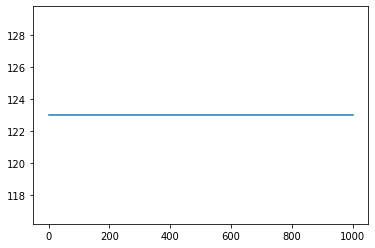

In [14]:


pmut_index = pmut[0]
crossover_index = crossover[3]
metodoSeleccionpadres_index = metodoSeleccionpadres[1]
gen_max_fitness_mean_list = []
max_fitness_mean_list = []





population = init_population(num_individuals, board, initialEntries)
best_ind, bestfitness, gen_max_fitness, max_fitness = genetic_algorithm(population, fitness_fn, ngen = ngen,
                                          pmut = pmut_index,
                                          pcx = pcx,
                                          tournament_size = tournament_size, 
                                          crossover = crossover_index,
                                          mutation = mutation[0],
                                          selection_parents_method = metodoSeleccionpadres_index,
                                          selection_survivors_method = metodoSeleccionsobrevivientes[0])
plt.plot(bestfitness)
plt.show()




                

Poblacion inicial, best_fitness = 119
Best board found in 1.4683313369750977 seconds (1000 ierations) with 150/162 points:
Last Gen with improvement:  453


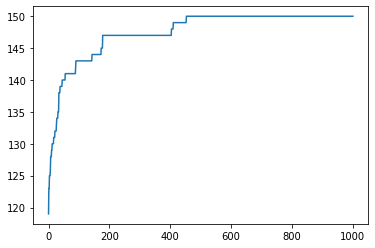

In [15]:


pmut_index = pmut[3]
crossover_index = crossover[1]
metodoSeleccionpadres_index = metodoSeleccionpadres[1]
gen_max_fitness_mean_list = []
max_fitness_mean_list = []





population = init_population(num_individuals, board, initialEntries)
best_ind, bestfitness, gen_max_fitness, max_fitness = genetic_algorithm(population, fitness_fn, ngen = ngen,
                                          pmut = pmut_index,
                                          pcx = pcx,
                                          tournament_size = tournament_size, 
                                          crossover = crossover_index,
                                          mutation = mutation[0],
                                          selection_parents_method = metodoSeleccionpadres_index,
                                          selection_survivors_method = metodoSeleccionsobrevivientes[0])
plt.plot(bestfitness)
plt.show()




                